In [ ]:
import tensorflow as tf

if tf.test.is_gpu_available():
    device_name = tf.test.gpu_device_name()

else:
    device_name = 'CPU:0'
    
print(device_name)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


/device:GPU:0


In [ ]:
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

定義 生成器與鑑別器

In [ ]:
def dcgan_gen(z_size = 20,
              optput_size = (28,28,1),
              n_filters = 128,
              n_blocks = 2):
    
    size_factor = 2**n_blocks
    hidden_size = (optput_size[0]//size_factor,
                   optput_size[1]//size_factor)
    #建立模組
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(z_size)),
        
        tf.keras.layers.Dense(units=n_filters*np.prod(hidden_size),use_bias=False),     #128*7*7=6272
        
        tf.keras.layers.BatchNormalization(), #已包含偏移參數beta        
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Reshape((hidden_size[0],hidden_size[1],n_filters)),     #7*7*128
        
        tf.keras.layers.Conv2DTranspose(filters=n_filters,
                                        kernel_size=(5,5),strides=(1,1),
                                        padding='same',use_bias=False),  #內核(5,5) 步伐 = (1,1) 相同填補
        tf.keras.layers.BatchNormalization(),
         tf.keras.layers.LeakyReLU()       
    ])
    
    
    nf = n_filters
    for i in range(n_blocks):
        nf = nf//2
        model.add(tf.keras.layers.Conv2DTranspose(filters=nf,
                                                  kernel_size=(5,5),strides=(2,2),
                                                  padding='same',use_bias=False))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
        
    model.add(tf.keras.layers.Conv2DTranspose(filters=optput_size[2],
                                              kernel_size=(5,5),strides=(1,1),
                                              padding='same',use_bias=False,
                                              activation='tanh')) 
    return model

def dcgan_disc(input_size=(28,28,1),
                       n_filters=64,
                       n_blocks=2):
    
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_size),
        tf.keras.layers.Conv2D(filters=n_filters,kernel_size=5,
                    strides=(1,1),padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU()
    ])
    
    
    nf = n_filters
    for i in range(n_blocks):
        nf = nf*2
        model.add(tf.keras.layers.Conv2D(filters=nf,kernel_size=(5,5),
                                         strides=(2,2),padding='same'))
        
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(0.3))
        
    model.add(tf.keras.layers.Conv2D(filters=1,kernel_size=(7,7),
                                      padding='valid'))
    
    model.add(tf.keras.layers.Reshape((1,)))
    
    return model

In [ ]:
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnist = mnist_bldr.as_dataset(shuffle_files = False)

def preprocess(ex, mode='uniform'):                         #資料預處理
    image = ex['image']
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image*2 - 1.0
    input_z = tf.random.uniform(shape=(z_size,), minval=-1.0, maxval=1.0)
    return input_z, image


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
num_epochs = 50
batch_size = 128
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'
lambda_gp = 10.0

tf.random.set_seed(1)
np.random.seed(1)

#  資料建立
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(preprocess)

mnist_trainset = mnist_trainset.shuffle(10000)
mnist_trainset = mnist_trainset.batch(
    batch_size, drop_remainder=True)

## 模組建立
with tf.device(device_name):
    gen_model = dcgan_gen()
    gen_model.build(input_shape=(None, z_size))
    gen_model.summary()

    disc_model =dcgan_disc()
    disc_model.build(input_shape=(None, np.prod(image_size)))
    disc_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              125440    
                                                                 
 batch_normalization (BatchN  (None, 6272)             25088     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        409600    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [ ]:

import time


# 優化器
g_optimizer = tf.keras.optimizers.Adam(0.002)
d_optimizer = tf.keras.optimizers.Adam(0.002)


fixed_z = tf.random.normal(shape=(batch_size, z_size))

def create_samples(g_model, input_z):
    g_output = g_model(input_z, training=False)
    images = tf.reshape(g_output, (batch_size, *image_size))    
    return (images+1)/2.0

all_losses = []
epoch_samples = []

start_time = time.time()

for epoch in range(1, num_epochs+1):
    epoch_losses = []
    for i,(input_z,input_real) in enumerate(mnist_trainset):
        
        # 計算鑑別器損失梯度:
        with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
            g_output = gen_model(input_z, training=True)
            
            d_critics_real = disc_model(input_real, training=True)
            d_critics_fake = disc_model(g_output, training=True)

            # 計算生成器損失
            g_loss = -tf.math.reduce_mean(d_critics_fake)

            # 計算鑑別器損失
            d_loss_real = -tf.math.reduce_mean(d_critics_real)
            d_loss_fake =  tf.math.reduce_mean(d_critics_fake)
            d_loss = d_loss_real + d_loss_fake

            # 梯度懲罰
            with tf.GradientTape() as gp_tape:
                alpha = tf.random.uniform(
                    shape=[d_critics_real.shape[0], 1, 1, 1], 
                    minval=0.0, maxval=1.0)
                interpolated = (
                    alpha*input_real + (1-alpha)*g_output)
                gp_tape.watch(interpolated)
                d_critics_intp = disc_model(interpolated)
            
            grads_intp = gp_tape.gradient(
                d_critics_intp, [interpolated,])[0]
            grads_intp_l2 = tf.sqrt(
                tf.reduce_sum(tf.square(grads_intp), axis=[1, 2, 3]))
            grad_penalty = tf.reduce_mean(tf.square(grads_intp_l2 - 1.0))
        
            d_loss = d_loss + lambda_gp*grad_penalty
        
        ## 應用優化器計算鑑別器和優化器梯度
        d_grads = d_tape.gradient(d_loss, disc_model.trainable_variables)
        d_optimizer.apply_gradients(
            grads_and_vars=zip(d_grads, disc_model.trainable_variables))
        
        g_grads = g_tape.gradient(g_loss, gen_model.trainable_variables)
        g_optimizer.apply_gradients(
            grads_and_vars=zip(g_grads, gen_model.trainable_variables))

        epoch_losses.append(
            (g_loss.numpy(), d_loss.numpy(), 
             d_loss_real.numpy(), d_loss_fake.numpy()))
                    
    all_losses.append(epoch_losses)
    
    print('Epoch {:-3d} | ET {:.2f} min | Avg Losses >>'
          ' G/D {:6.2f}/{:6.2f} [D-Real: {:6.2f} D-Fake: {:6.2f}]'
          .format(epoch, (time.time() - start_time)/60, 
                  *list(np.mean(all_losses[-1], axis=0)))
    )
    
    epoch_samples.append(
        create_samples(gen_model, fixed_z).numpy()
    )

Epoch   1 | ET 2.37 min | Avg Losses >> G/D 346.95/-639.62 [D-Real: -365.83 D-Fake: -346.95]
Epoch   2 | ET 4.02 min | Avg Losses >> G/D 269.12/-102.70 [D-Real: -179.42 D-Fake: -269.12]
Epoch   3 | ET 5.66 min | Avg Losses >> G/D 164.83/-25.47 [D-Real: -69.73 D-Fake: -164.83]
Epoch   4 | ET 7.29 min | Avg Losses >> G/D 141.54/ 20.47 [D-Real:   3.29 D-Fake: -141.54]
Epoch   5 | ET 8.92 min | Avg Losses >> G/D  89.81/ 13.20 [D-Real:  11.06 D-Fake: -89.81]
Epoch   6 | ET 11.28 min | Avg Losses >> G/D  62.29/  9.82 [D-Real:  11.24 D-Fake: -62.29]
Epoch   7 | ET 12.92 min | Avg Losses >> G/D  84.18/-18.64 [D-Real:  36.67 D-Fake: -84.18]
Epoch   8 | ET 14.55 min | Avg Losses >> G/D  80.52/-34.27 [D-Real:  35.91 D-Fake: -80.52]
Epoch   9 | ET 16.18 min | Avg Losses >> G/D  73.07/-41.09 [D-Real:  15.99 D-Fake: -73.07]
Epoch  10 | ET 17.81 min | Avg Losses >> G/D  57.60/-32.52 [D-Real:  14.32 D-Fake: -57.60]
Epoch  11 | ET 20.18 min | Avg Losses >> G/D  69.35/-36.47 [D-Real:  23.45 D-Fake: -69.

# 新增區段

In [ ]:
gen_model.save('WDCGAN-gan_gen.h5')
disc_model.save('WDCGAN-gan_disc.h5')

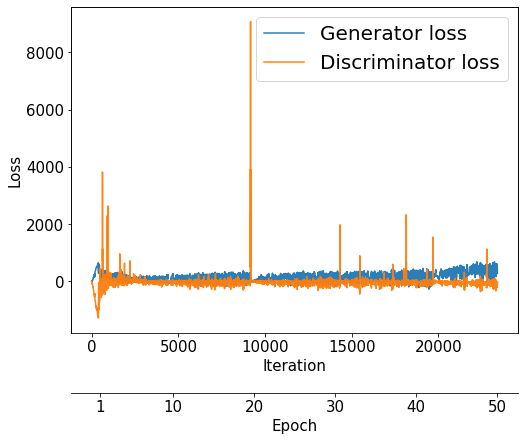

In [ ]:
import itertools


fig = plt.figure(figsize=(8, 6))

# 損失率視覺化
ax = fig.add_subplot(1, 1, 1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1] for item in itertools.chain(*all_losses)]
plt.plot(g_losses, label='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha=0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

epochs = np.arange(1, 101)
epoch2iter = lambda e: e*len(all_losses[-1])
epoch_ticks = [1, 10, 20, 30, 40, 50]
newpos   = [epoch2iter(e) for e in epoch_ticks]
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 40))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

plt.savefig('curve.pdf')
plt.show()

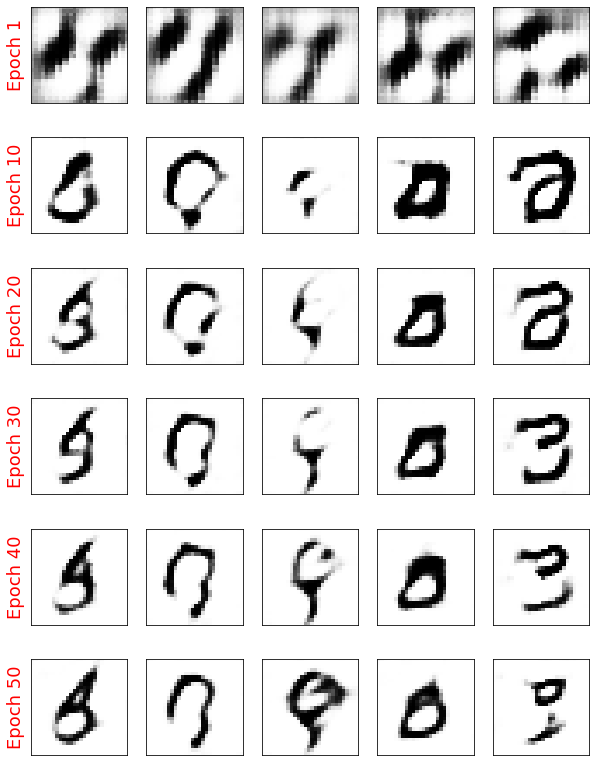

In [ ]:
#每輪[1, 10, 20, 30, 40, 50]情況

selected_epochs = [1, 10, 20, 30, 40, 50]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, 'Epoch {}'.format(e),
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')
    
plt.savefig('wdcgan-samples.pdf')
plt.show()